# A Flax Optimization Cookbook

This notebook goes through some common problems in nontrivial training loops for Flax models. For clarity, all sections below will be training the following toy model. We allow extra keyword arguments so that the sharding and dtype can be determined on an instance by instance basis. 

In [1]:
import jax
from flax import nnx
jax.config.update('jax_num_cpu_devices', 8)
import jax.numpy as jnp
import functools as ft
import matplotlib.pyplot as plt

param_init = jax.nn.initializers.lecun_normal()

rngs = nnx.Rngs(0)

def make_model(rngs, **kwargs):
    return nnx.Sequential(
        nnx.Linear(2,8, rngs=rngs, kernel_init=ft.partial(param_init, **kwargs)),
        nnx.Linear(8,8, rngs=rngs, kernel_init=ft.partial(param_init, **kwargs)))

def loss_fn(model, x, y):
    return jnp.sum((model(x) - y) ** 2)

We'll operate on the following fake data:

In [2]:
x = rngs.normal((32, 2))
y = rngs.normal((32, 8))

# Exponential Moving Average

Neural network see increased robustness when, rather than using only the weights available at the end of training, we use an exponential moving average of the weights produced throughout training. It is easy to modify the standard Flax training loop to accomodate calculating exponential moving averages. 

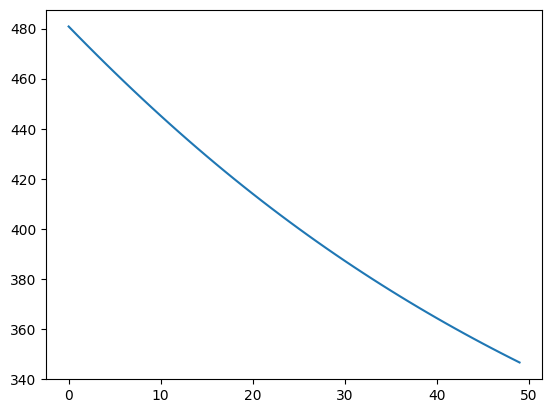

In [4]:
import optax
from jax import tree

class Ema(nnx.Module):
    def __init__(self, model, decay=0.9):
        self.decay = decay
        self.ema = nnx.clone(model)
    def update(self, model):
        def ema_update(ema, new_val):
          return self.decay * ema + (1 - self.decay) * new_val
        self.ema = tree.map(ema_update, self.ema, model)

model = make_model(rngs)
ema = Ema(model)

optimizer = nnx.Optimizer(
  model,
  tx=optax.adam(1e-3),
  wrt=nnx.Param)

@nnx.jit
def train_step(model, optimizer, ema, x, y):
  loss, grads = nnx.value_and_grad(loss_fn)(model, x, y)
  optimizer.update(model, grads)
  ema.update(model)
  return loss

losses = []
for _ in range(50):
  loss = train_step(model, optimizer, ema, x, y)
  losses.append(loss)
plt.plot(losses)

# Low Rank Adaptation

The pattern for adding low rank adaptation to an optimization loop is very similar to adding an exponential moving average. As before, we create a new pytree with the same structure as our model parameters, but here we store low rank additions to these parameters rather than weighted average values. 

In [5]:
def add_rank2_lora(path, node):
  if isinstance(node, nnx.Linear):
    return nnx.LoRA(node.in_features, 2, node.out_features, base_module=node, rngs=rngs)
  return node

base_model = make_model(rngs)
lora_model = nnx.recursive_map(add_rank2_lora, base_model)
nnx.display(lora_model)

To indicate that we only want to to update the low rank corrections, we add the `wrt=nnx.LoRAParam` argument to `nnx.Optimizer`. This will filter out all the variables in the gradient that are not `nnx.LoRAParam`s. The other components of the gradient will go unused, so Jax's dead code elimination passes should prevent us from computing them in the first place once the code gets compiled. 

In [6]:
@nnx.jit
def train_step(model, optimizer, x, y):
  loss, grads = nnx.value_and_grad(loss_fn)(model, x, y)
  optimizer.update(model, grads)
  return loss

optimizer = nnx.Optimizer(
  lora_model,
  tx=optax.adam(1e-3),
  wrt=nnx.LoRAParam,
)

losses = []
for _ in range(50):
  loss = train_step(lora_model, optimizer, x, y)
  losses.append(loss)

# LBFGS

So far, we've been using optax optimizers with the interface ``optimizer.update(grads, opt_state)``. This works for simple optimization algorithms like ADAM, but for algorithms that use a line search like LBFGS, we need to pass more parameters. Below, we can see how the call to ``optimizer.update`` is given additional parameters when using LBFGS.

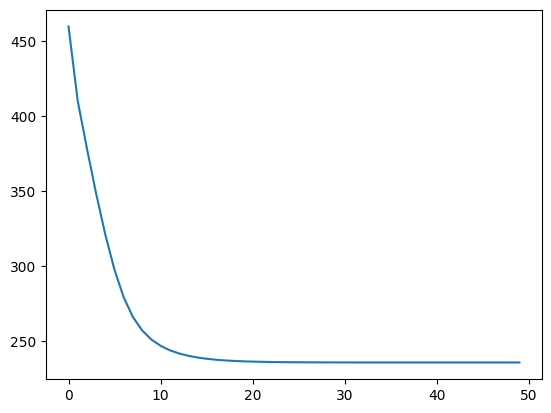

In [7]:
def train_step(model, optimizer, x, y):
    # Create state-based loss function for LBFGS
    graphdef = nnx.graphdef(model)
    loss_fn_state = lambda state: loss_fn(nnx.merge(graphdef, state), x, y)

    loss, grads = nnx.value_and_grad(loss_fn)(model, x, y)
    optimizer.update(
      model,
      grads,
      grad=grads,
      value=loss,
      value_fn=loss_fn_state)
    return loss

model = make_model(rngs)
optimizer = nnx.Optimizer(
  model,
  tx=optax.lbfgs(1e-3),
  wrt=nnx.Param)

losses = []
for _ in range(50):
  loss = train_step(model, optimizer, x, y)
  losses.append(loss)
plt.plot(losses)

# Per-Parameter Learning Rates

In some training regimes, you will want to optimize different parameters with different learning rates.

In Jax, we map from each leaf to the type of parameter it is (weight or bias). We then create a dictionary giving the learning rates to use for each parameter type. Finally, we can make a compound optimizers that uses each rate appropriately.

To do this in Flax, we can map from each leaf to the type of parameter it is (weight or bias). With this pytree of parameter types, we can make a compound optimizer that uses each rate appropriately. 

In [8]:
model = make_model(rngs)
state = nnx.state(model, nnx.Param)
rates = {'kernel': optax.adam(1e-3), 'bias': optax.adam(1e-2)}
param_tys = nnx.map_state(lambda p, v: list(p)[-1], state)
optimizer = nnx.Optimizer(model, tx=optax.partition(rates, param_tys), wrt=nnx.Param)

@nnx.jit
def train_step(model, optimizer, x, y):
  loss, grads = nnx.value_and_grad(loss_fn)(model, x, y)
  optimizer.update(model, grads)
  return loss

losses = []
for _ in range(50):
  loss = train_step(model, optimizer, x, y)
  losses.append(loss)

# Gradient Accumulation

Gradient accumulation in Flax is easy: just use the `optax.MultiSteps` optimizer.

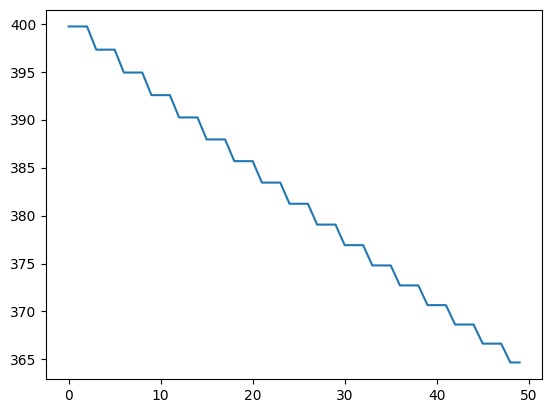

In [9]:
model = make_model(rngs)
optimizer = nnx.Optimizer(model, tx=optax.MultiSteps(optax.adam(1e-3), every_k_schedule=3), wrt=nnx.Param)

@nnx.jit
def train_step(model, optimizer, x, y):
  loss, grads = nnx.value_and_grad(loss_fn)(model, x, y)
  optimizer.update(model, grads)
  return loss

losses = []
for _ in range(50):
  loss = train_step(model, optimizer, x, y)
  losses.append(loss)
plt.plot(losses)

# Sharding Optimization State Differently from Parameters

Say we're doing data parallelism. We want to replicate our parameters across all GPUs so we can do the forward and backward passes without communication latency.

But we don't need to replicate the optimizer state, as it's not invovled in SPMD computations. One copy is enough, and we can shard this copy across our mesh to reduce memory usage. This means that we need the optimizer state to be sharded differently from the parameters themselves.

To do this, we can pass the params initializer given the the optimizer a `sharding` argument. This will shard the optimization state the same way. But when we initialize the model parameters themselves, we won't provide a sharding, allowing for data parallelism.

In [10]:
from jax.sharding import PartitionSpec as P, AxisType, get_abstract_mesh, reshard
mesh = jax.make_mesh((2, 4), ("x", "y"),
                      axis_types=(AxisType.Explicit, AxisType.Explicit))
jax.set_mesh(mesh)

ghost_model = jax.eval_shape(lambda: make_model(nnx.Rngs(0), out_sharding=P('x', 'y')))
optimizer = nnx.Optimizer(ghost_model, optax.adam(1e-3), wrt=nnx.Param)
model = make_model(rngs)

@nnx.jit
def train_step(model, optimizer, x, y):
  loss, grads = nnx.value_and_grad(loss_fn)(model, x, y)
  optimizer.update(model, grads)
  return loss

losses = []
for _ in range(50):
  loss = train_step(model, optimizer, x, y)
  model = reshard(model, P(None, None))
  losses.append(loss)

The optimizer state is sharded:

In [11]:
jax.typeof(optimizer.opt_state[0][1].layers[0]['kernel'][...])

ShapedArray(float32[2@x,8@y])

But the model is not:

In [12]:
jax.typeof(model.layers[0].kernel[...])

ShapedArray(float32[2,8])